In [1]:
# from __future__ import print_function
import time
import cv2
from OpticalFlowShowcase import *
import numpy as np
import argparse
import io
import sys
import datetime
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from memory_profiler import profile
from uncertainties import unumpy
import uncertainties as u
import ucert
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import colorlover as cl
from IPython.display import HTML

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
def printColor(color): HTML(cl.to_html( cl.scales['11']['div'][color] ))

In [5]:
def process(file):
    numObj = np.load(file)
    [date, arr] = numObj
    return [date, arr]

In [6]:
# Not really needed for this
def localize(point, x, y, mv = 0.08):
    Z = 1/np.power(np.power(point[0]-x,2)+np.power(point[1]-y,2),0.5)
    Z[ Z > mv ] = mv
    return Z*(1/mv)

In [7]:
def pythag(arr):
    # This is going to reduce the system into one array ~ ideally ~ a mxm matrix of rank 2
    finalArr = np.zeros(arr.shape[:-1],dtype='float32')
    for i in range(arr.shape[-1]):
        finalArr += np.power(arr[...,i], 2)
    return np.power(finalArr, 0.5)

In [8]:
def edge(arr, scope):
    if len(scope) == 2:
        lowerBound_x = lowerBound_y = scope[0]
        upperBound_x = upperBound_y = scope[1]
    elif len(scope) == 4:
        lowerBound_x = scope[0]; lowerBound_y = scope[2]
        upperBound_x = scope[1]; upperBound_y = scope[3]
    else: return None
    x_ = arr.shape[0]; y_ = arr.shape[1]
    return arr[int(x_*lowerBound_x):int(x_*upperBound_x),int(y_*lowerBound_y):int(y_*upperBound_y),:]

In [9]:
def gradient(array): return np.gradient(array) #np.add.reduce(np.gradient(array))

In [10]:
def importMatrix(file):
    num_cols = 2
    converters = dict.fromkeys(
        range(num_cols),
        lambda col_bytes: u.ufloat_fromstr(col_bytes.decode("latin1")))
    arr = np.loadtxt(file, converters=converters, dtype=object)
    return arr.reshape((64,64,2))

In [11]:
def printArr(arr, color, titleName):
    # Allows us to work with the shape off the photo we're looking at
    numPoints = 11
    colorSeries = cl.scales[str(numPoints)]['div'][color]
    xPoints = [ i/float(numPoints-1) for i in range(0,numPoints) ]
    colorSeries = [ [xPoints[c], i] for c,i in enumerate(colorSeries) ]
    print(colorSeries)
    if len(arr.shape) == 2:
        x_dist = np.arange(0,arr.shape[0])
        y_dist = np.arange(0,arr.shape[1])

        x, y = np.meshgrid(x_dist, y_dist)
        z = arr

        textz=[['x: '+'{:0.5f}'.format(x[i][j])+'<br>y: '+'{:0.5f}'.format(y[i][j])+
            '<br>z: '+'{:0.5f}'.format(z[i][j]) for j in range(z.shape[1])] for i in range(z.shape[0])]

        trace1= go.Surface(z=z,
                    x=x,
                    y=y,
                    colorscale=colorSeries,
                    cauto=True,
                    text=textz,
                    hoverinfo='x, y, z',
                    )

        axis = dict(
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            showgrid=True,
            zeroline=True,
            showline=False
        )

        ztickvals=list(x_dist)
        layout = go.Layout(title=titleName, autosize=True)

        textx=[['y: '+'{:0.5f}'.format(y[i][j])+'<br>z: '+'{:0.5f}'.format(z[i][j])+
                '<br>x: '+'{:0.5f}'.format(x[i][j]) for j in range(z.shape[1])]  for i in range(z.shape[0])]
        texty=[['x: '+'{:0.5f}'.format(x[i][j])+'<br>z: '+'{:0.5f}'.format(z[i][j]) +
                '<br>y: '+'{:0.5f}'.format(y[i][j]) for j in range(z.shape[1])] for i in range(z.shape[0])]
        marker = go.Scatter3d( x=[0], y=[0], z=[0],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.2),
                opacity=0.8))

        data=[trace1, marker]
        fig = go.Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)
    elif len(arr.shape) >= 2:
        x_dist = np.arange(0,arr[0].shape[0])
        y_dist = np.arange(0,arr[0].shape[1])

        x, y = np.meshgrid(x_dist, y_dist)
        z0 = arr[0]
        z1 = arr[1]

        textz0=[['x: '+'{:0.5f}'.format(x[i][j])+'<br>y: '+'{:0.5f}'.format(y[i][j])+
            '<br>z: '+'{:0.5f}'.format(z0[i][j]) for j in range(z0.shape[1])] for i in range(z0.shape[0])]
        textz1=[['x: '+'{:0.5f}'.format(x[i][j])+'<br>y: '+'{:0.5f}'.format(y[i][j])+
            '<br>z: '+'{:0.5f}'.format(z1[i][j]) for j in range(z1.shape[1])] for i in range(z1.shape[0])]

        trace1= go.Surface(z=z0,
                    x=x,
                    y=y,
                    colorscale=color,
                    cauto=True,
                    text=textz0,
                    hoverinfo='x, y, z',
                    )
        trace2= go.Surface(z=z1,
                    x=x,
                    y=y,
                    colorscale=color,
                    cauto=True,
                    text=textz1,
                    hoverinfo='x, y, z',
                    )

        axis = dict(
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            showgrid=True,
            zeroline=True,
            showline=False
        )

        ztickvals=list(x_dist)
        layout = go.Layout(title=titleName, autosize=True)
        z0_offset=np.min(z0)*np.ones(z0.shape)
        z1_offset=np.max(z0)*np.ones(z1.shape)#
        x_offset=np.min(x_dist)*np.ones(z0.shape)
        y_offset=np.min(y_dist)*np.ones(z0.shape)

        textx=[['y: '+'{:0.5f}'.format(y[i][j])+'<br>z: '+'{:0.5f}'.format(z0[i][j])+
                '<br>x: '+'{:0.5f}'.format(x[i][j]) for j in range(z0.shape[1])]  for i in range(z0.shape[0])]
        texty=[['x: '+'{:0.5f}'.format(x[i][j])+'<br>z: '+'{:0.5f}'.format(z0[i][j]) +
                '<br>y: '+'{:0.5f}'.format(y[i][j]) for j in range(z0.shape[1])] for i in range(z0.shape[0])]
        marker = go.Scatter3d(
            x=[0],
            y=[0],
            z=[0],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.2
                ),
                opacity=0.8
            )
        )
        print("THIS WAS RUN")
        data=[trace1, trace2, marker]
        fig = go.Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)

In [12]:
# Shouldn't really be needed

def normalize(x):
    return x/np.amax(np.absolute(x))

In [13]:
def intensity(x):
    # This is taking the hypotenuse of the intensity vectors
    assert type(x).__module__ == np.__name__
    return np.power(np.sum(np.power(x,2),axis=len(x.shape)-1),0.5) # pythagorean

In [44]:
A = np.load('aw_motion_wk7.npy')

In [45]:
A = edge(A, (0.2, 0.74))

This function is looking to take something with an X and Y system to decompose it into a collapsed major system

In [46]:
# A = pythag(A)

In [47]:
print(A.shape)

(35, 35, 2)


This function yields the gradient (velocities at each given point within the graph - it's in experimental mode at the moment and prone to failure as it changes the dimensions of the matrix)

In [48]:
# A = gradient(A[...,0])

This code block underneath will normalize any matrix, showing relative weight between the matrices

In [49]:
print(A.shape)

(35, 35, 2)


In [35]:
# A = normalize(A)

In [25]:
import matplotlib.pyplot as plt
X = np.linspace(min_val,max_val,num=y_avg.shape[0])
y_motion = A[...,1]; x_motion = A[...,0];
y_avg = np.sum(y_motion, axis=1)
max_val = np.max(y_motion.shape); min_val = 0
X = X.astype('float64'); y_avg = y_avg.astype('float64')
plt.plot(X,y_avg,'o')
print(X, y_avg)

[ 0.          0.0277551   0.0555102   0.08326531  0.11102041  0.13877551
  0.16653061  0.19428571  0.22204082  0.24979592  0.27755102  0.30530612
  0.33306122  0.36081633  0.38857143  0.41632653  0.44408163  0.47183673
 -0.47183673 -0.44408163 -0.41632653 -0.38857143 -0.36081633 -0.33306122
 -0.30530612 -0.27755102 -0.24979592 -0.22204082 -0.19428571 -0.16653061
 -0.13877551 -0.11102041 -0.08326531 -0.0555102  -0.0277551 ]
(35, 35, 2)


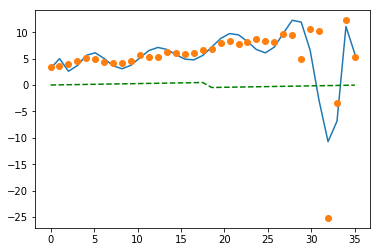

In [30]:
V = np.polyfit(X,y_avg,12)
Y = np.poly1d(V)
fourier = np.fft.fft(y_avg); n = y_avg.size;
timestep = X[1]-X[0]; freq = np.fft.fftfreq(n, d=timestep)
print(freq)
plt.plot(X,Y(X),'-',X,y_avg,'o',X,freq,'g--')
print(A.shape)

This is a system of normalizing

In [51]:
printArr(A[...,0], 'Spectral', "X Motion of the data")

[[0.0, 'rgb(158,1,66)'], [0.1, 'rgb(213,62,79)'], [0.2, 'rgb(244,109,67)'], [0.3, 'rgb(253,174,97)'], [0.4, 'rgb(254,224,139)'], [0.5, 'rgb(255,255,191)'], [0.6, 'rgb(230,245,152)'], [0.7, 'rgb(171,221,164)'], [0.8, 'rgb(102,194,165)'], [0.9, 'rgb(50,136,189)'], [1.0, 'rgb(94,79,162)']]


In [1143]:
HTML(cl.to_html(cl.scales));